## Introduction

Inspired by several recent high-profile missing persons cases, including that of <a href="http://www.boston.com/news/local/massachusetts/2016/03/16/zachary-marr-death-horrible-accident-family-says/SbD1sbu3DqcilneDOvQOgM/story.html" target="_blank">Zachary Marr</a>, I wanted to learn more about the cases that don't make the news every night.
      
My general questions were:
   
      How many people in the Boston area go missing every year, and of these, how many are found?
      When and where do people go missing?
      When and where are they found?
      
For answers, I looked to the <a href="https://data.cityofboston.gov/Public-Safety/Crime-Incident-Reports/7cdf-6fgx" target="_blank">Crime Incident Reports</a> provided by the Boston Police Department and published through the city's open data portal at <a href = "https://data.cityofboston.gov" target="_blank">data.cityofboston.gov</a>.  

### Loading the Data

My goals were to A) accurately select the missing persons cases, and B) classify each missing persons incident as either being when the person was reported missing or was found.

There are three fields for generally categorizing the type of incident, with a range of values that relate to missing persons cases:

<table>
<tr>
<th>Field</th>
<th>Values</th>
</tr>

<tr>
<td>Nature Code</td>
<td>
<ul><li>MISPER</li>
<li>I00027</li>
</ul></td>
</tr>

<tr>
<td>Incident Type Description</td>
<td>
<ul><li>PersLoc</li>
<li>PersMiss</li>
<li>Missing Person Located</li>
<li>Missing Person Reported</li>
</ul></td>
</tr>

<tr>
<td>Main Crime Code</td>
<td>
<ul><li>PersLoc</li>
<li>PersMiss</li>
<li>PersFound</li>
</ul></td>
</tr>

</table>



In [1]:
# Import python packages

import numpy as np
import pandas as pd
from pandas import Series,DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

import requests

# Make plots visible in notebook

%matplotlib inline

C:\Users\garymiller01\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Search query 

p = {'$limit':'10000',
"$where":"main_crimecode='PersFound' OR main_crimecode='PersMiss' OR main_crimecode='PersLoc' OR naturecode='MISPER' OR naturecode='I00027'",
     "$order":"fromdate" 
    }

myheaders = {'X-App-Token':'beKhBToX5TgqkdbzDnJaHeXNZ'}

url = "https://data.cityofboston.gov/resource/7cdf-6fgx.json"

# Read in dataset

r = requests.get(url,params=p,headers=myheaders)

In [3]:
# Convert result from JSON object into Pandas dataframe

df = pd.DataFrame(r.json())

# Take a look

df.tail()

,compnos,day_week,domestic,fromdate,incident_type_description,location,main_crimecode,month,naturecode,reportingarea,reptdistrict,shift,shooting,streetname,ucrpart,weapontype,x,xstreetname,y,year
6334,NaN,Sunday,No,2015-08-09T00:00:00,Missing Person Reported,"{'longitude': '-71.1191551211726', 'needs_reco...",PersMiss,8,IVPER,498,E18,NaN,No,CLARE AVE,Part Three,None,759242,NULL,2920000,2015
6335,NaN,Sunday,No,2015-08-09T00:00:00,Investigate Person,"{'longitude': '-71.0954533712696', 'needs_reco...",InvPer,8,I00027,466,B3,NaN,No,ORMOND ST,Part Three,None,765636,NULL,2930000,2015
6336,NaN,Sunday,No,2015-08-09T18:45:00,Missing Person Reported,"{'longitude': '0.0', 'needs_recoding': False, ...",PersMiss,8,I00027,0,NULL,NaN,No,HUNTINGTON AVE,Part Three,None,NaN,NULL,NaN,2015
6337,NaN,Sunday,No,2015-08-09T20:20:00,Missing Person Reported,"{'longitude': '0.0', 'needs_recoding': False, ...",PersMiss,8,I00027,606,E13,NaN,No,HUNTINGTON AVE,Part Three,None,NaN,S HUNTINGTON AVE,NaN,2015
6338,NaN,Monday,No,2015-08-10T00:00:00,Missing Person Reported,"{'longitude': '-71.1263254029292', 'needs_reco...",PersMiss,8,I00027,542,E18,NaN,No,BUSINESS ST,Part Three,None,757329,NULL,2920000,2015


### Cleaning the Data

Several columns contain information that doesn't really relate to missing persons cases, so could be dropped.   

As of 3/16/2016, the dataset included incidents reported between 7/8/2012 and 8/10/2015.  I wanted to be able to compare full years, so I dropped partial year data from the dataframe.  All ensuing analysis covers 2013 and 2014 only.

To map each incident, separate latitude and longitude columns were needed.  These values (in units of decimal degrees) were nested within the location field. The 'X' and 'Y' column values are State Plane coordinates, which could also be dropped.

Finally, I created a new Case Type column to uniformly classify each incident as a person having been found or reported as missing.  First, I looked for a description of 'PersLoc' or 'PersMiss' from the Incident Type Description field.  As it turned out, during this time frame, these entries perfectly matched the Main Crime Code field values.  The remaining incidents, identified as 'MISPER' in the Nature Code field but with other values in the Incident Type and Main Crime Code fields, I categorized as 'Unknown'. 

In [4]:
# Keep only useful columns

cols = ['compnos','day_week','fromdate','location','incident_type_description',
        'main_crimecode','month','naturecode','shift','year']

df = df[cols]

In [5]:
# Find earliest date

df['fromdate'].min()

'2012-07-08T11:10:00'

In [6]:
# Find latest date

df['fromdate'].max()

'2015-08-10T00:00:00'

In [7]:
# Include in df rows only where the year is 2013 or 2014

df = df.loc[df['year'].isin(['2013','2014'])]

In [8]:
# See revised dataframe

df.head()

,compnos,day_week,fromdate,location,incident_type_description,main_crimecode,month,naturecode,shift,year
923,130000030,Tuesday,2013-01-01T00:15:00,"{'longitude': '-71.09393329', 'needs_recoding'...",PersLoc,PersLoc,1,MSNCOM,Last,2013
924,130002665,Tuesday,2013-01-01T00:30:00,"{'longitude': '-71.07790954', 'needs_recoding'...",PersLoc,PersLoc,1,MSNCOM,Last,2013
925,130000587,Tuesday,2013-01-01T05:24:00,"{'longitude': '-71.08194955', 'needs_recoding'...",PersLoc,PersLoc,1,MISPER,Last,2013
926,130001702,Tuesday,2013-01-01T06:11:00,"{'longitude': '-71.05463956', 'needs_recoding'...",PersLoc,PersLoc,1,MISPER,Last,2013
927,130000763,Tuesday,2013-01-01T09:32:00,"{'longitude': '-71.06680456', 'needs_recoding'...",PersMiss,PersMiss,1,MISPER,Day,2013


In [9]:
# Assign number of incidents to variable

rowcount = df.shape[0]

In [10]:
# Reset index values to range from 0 to the number of rows

df.index = np.arange(0,rowcount)

In [11]:
# Extract longitude values into separate list

longlist = []

longrange = np.arange(0,rowcount)

for i in longrange:
    long = df['location'][i]['longitude']
    longlist.append(long)
    
# Assign to new column in dataframe

df['longitude'] = longlist    

In [12]:
# Extract Latitude values into separate list

latlist = []

latrange = np.arange(0,rowcount)

for i in latrange:
    lat = df['location'][i]['latitude']
    latlist.append(lat)

# Assign to new column in dataframe    
    
df['latitude'] = latlist

In [13]:
# Drop location column

df = df.drop('location',axis=1)

In [14]:
# Add column with names of months

monthdict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
            '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December'}

df['monthname'] = df['month'].map(monthdict)

# Review revised dataframe

df.head(4)

,compnos,day_week,fromdate,incident_type_description,main_crimecode,month,naturecode,shift,year,longitude,latitude,monthname
0,130000030,Tuesday,2013-01-01T00:15:00,PersLoc,PersLoc,1,MSNCOM,Last,2013,-71.09393329,42.28284767,January
1,130002665,Tuesday,2013-01-01T00:30:00,PersLoc,PersLoc,1,MSNCOM,Last,2013,-71.07790954,42.31339636,January
2,130000587,Tuesday,2013-01-01T05:24:00,PersLoc,PersLoc,1,MISPER,Last,2013,-71.08194955,42.28295636,January
3,130001702,Tuesday,2013-01-01T06:11:00,PersLoc,PersLoc,1,MISPER,Last,2013,-71.05463956,42.32581635,January


In [15]:
# We now have 4315 incidents to analyze

df.shape

(4315, 12)

In [16]:
# Create CaseType column, filled with NAN

df['casetype'] = np.nan

# Get current incident type description field values

df['incident_type_description'].value_counts()

PersLoc                     3405
PersMiss                     764
InvPer                        93
Service                       16
MedAssist                     15
Runaway                        9
OTHER LARCENY                  2
Argue                          2
Arrest                         2
VIOLATION OF LIQUOR LAWS       1
CRIMES AGAINST CHILDREN        1
AGGRAVATED ASSAULT             1
TOWED                          1
OTHER                          1
DRUG CHARGES                   1
DISORDERLY                     1
Name: incident_type_description, dtype: int64

In [17]:
# Create dictionary mapping incident type descriptions to new labels

di = {'PersLoc':'Located','PersMiss':'Reported'}

# Create new 'casetype' column and populate based on Incident Type Description

df['casetype'] = df['incident_type_description'].map(di)

In [18]:
# See how many that missed

df['casetype'].value_counts(dropna=False)

Located     3405
Reported     764
NaN          146
Name: casetype, dtype: int64

In [19]:
# Fill in cases not described as located or reported with Nature Code value

df['casetype'].replace(np.nan,df['naturecode'],inplace=True)

In [20]:
df['casetype'].value_counts(dropna=False)

Located     3405
Reported     764
MISPER       146
Name: casetype, dtype: int64

In [21]:
# Change these to 'Unknown'

df['casetype'].replace('MISPER','Unknown',inplace=True)

In [22]:
df['casetype'].value_counts()

Located     3405
Reported     764
Unknown      146
Name: casetype, dtype: int64

In [23]:
# Rename 'compnos' column

df.rename(columns={'compnos':'incident'},inplace=True)

In [24]:
# Arrange Month, Day columns in proper order - convert to categorical datatype

dayOrder = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
df['day_week'] = df['day_week'].astype('category',categories=dayOrder,ordered=True)

monthOrder = ['January','February','March','April','May','June','July','August','September','October','November','December']
df['monthname'] = df['monthname'].astype('category',categories=monthOrder,ordered=True)

# Drop other columns

df = df.drop(['month','fromdate'],axis=1)

# Review revised dataframe

df.head()

,incident,day_week,incident_type_description,main_crimecode,naturecode,shift,year,longitude,latitude,monthname,casetype
0,130000030,Tuesday,PersLoc,PersLoc,MSNCOM,Last,2013,-71.09393329,42.28284767,January,Located
1,130002665,Tuesday,PersLoc,PersLoc,MSNCOM,Last,2013,-71.07790954,42.31339636,January,Located
2,130000587,Tuesday,PersLoc,PersLoc,MISPER,Last,2013,-71.08194955,42.28295636,January,Located
3,130001702,Tuesday,PersLoc,PersLoc,MISPER,Last,2013,-71.05463956,42.32581635,January,Located
4,130000763,Tuesday,PersMiss,PersMiss,MISPER,Day,2013,-71.06680456,42.29201136,January,Reported


### Analysis

   ####  How many incidents were reported each year, by casetype?
   
   Over two thousand incidents were reported each year (2,056 in 2013; 2,259 in 2014).  These were much higher totals than I expected.  What's also striking is the huge disparity between Located and Reported cases.  The Located casetype made up 77% of all incidents in 2013, and 81% in 2014;  I had expected a near even split.

   I reviewed the Crime Incident Reports and tried many variations of the search query in the hopes of finding these missing Reported incidents, but was unable to confidently identify them.  It's also possible that missing persons found in Boston may actually live in another city.  In these cases, the initial calls would probably be reported to other police departments, and so would not be represented in this dataset.  Given this uncertainty, I dropped the Reported and Unknown casetypes and focused solely on incidents where a missing person was located.
    

In [25]:
# Calculate count of incidents by year

yeardf = df.groupby(['casetype','year'])['incident'].count().reset_index()

yeartable=pd.pivot_table(data=yeardf,index='casetype',columns='year',aggfunc='sum',fill_value=0)

yeartable

incident      
year         2013  2014
casetype               
Located      1586  1819
Reported      379   385
Unknown        91    55

C:\Users\garymiller01\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


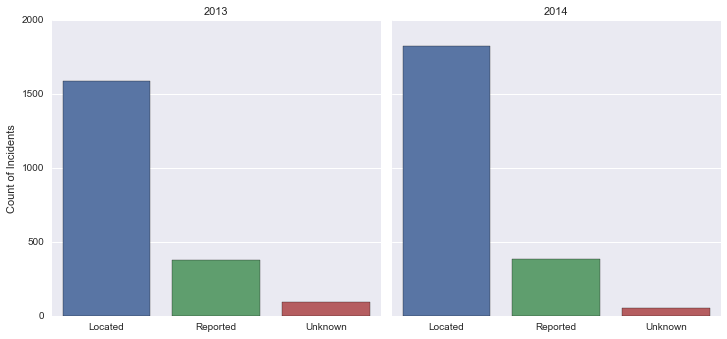

In [26]:
# Plot # of incidents by casetype and year

g = sns.factorplot(data=df,x='casetype',kind='count',col='year',size=5,aspect=1)
g.set_axis_labels('','Count of Incidents')
g.set_titles('{col_name}')


In [27]:
# Drop 'Reported' and 'Unknown' casetypes 

df = df.loc[df['casetype']=='Located']

df['casetype'].value_counts()


Located    3405
Name: casetype, dtype: int64

   #### What trends can be seen in looking at the data by month?
    
  There appears to be a seasonal cycle in the number of cases reported.  The counts are higher in Spring and early Summer (March, April, May, June), decrease in mid-summer and early Fall (June, July, August and September), picking back up in October and November), and declining again over the winter (December - February).  These swings generally coincide with when universities are in session, and the overall population of the city is higher.  Unfortunately, the dataset does not provide the ages (or any other demographic information) to test whether the possible correlation is significant.  
 
  In 2014, there were notable spikes in January and May as compared to the previous year.

In [28]:
# Calculate number of incidents by year and month

monthdf = df.groupby(['casetype','year','monthname'])['incident'].count().reset_index()

monthdf.sort_values(axis=0,by='monthname',inplace=True)

monthdf.head(4)

,casetype,year,monthname,incident
0,Located,2013,January,111
12,Located,2014,January,160
1,Located,2013,February,101
13,Located,2014,February,120


In [29]:
# Pivot table

monthtable=pd.pivot_table(data=monthdf,index='year',columns='monthname',aggfunc='sum',fill_value=0)

monthtable

incident                                                       \
monthname  January February March April  May June July August September   
year                                                                      
2013           111      101   142   126  159  147  112    120       118   
2014           160      120   134   158  213  169  144    137       141   

                                     
monthname October November December  
year                                 
2013          150      166      134  
2014          149      157      137

C:\Users\garymiller01\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Users\garymiller01\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


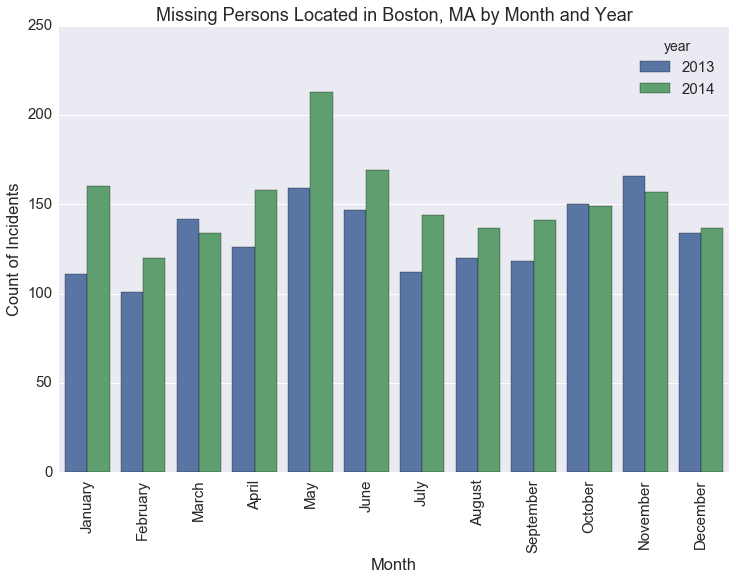

In [30]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(data=df,x='monthname',hue='year',ax=ax)
ax.set_title('Missing Persons Located in Boston, MA by Month and Year')
ax.set_xlabel('Month')
ax.set_ylabel('Count of Incidents')
ax.set_xticklabels(monthOrder,rotation=90)
plt.show()


  #### What days of the the week and during what shifts see the highest and lowest numbers of incidents?
  
  More missing persons were located on Fridays than any other day of the week, in both 2013 and 2014.  Saturday ranked second, also in both years.  Fewer incidents were reported Sunday through Thursday, with the exception of Mondays in 2014. 
  
  The Last shift had far fewer reported incidents than either Days or First.  The heatmap below shows that First and Days on Fridays were the peak shifts, while Sunday and Thursday nights had the fewest cases.

In [31]:
# Count Incidents by Day and Year

daydf = df.groupby(['year','day_week'])['incident'].count().reset_index()

daypivot = pd.pivot_table(data=daydf,index='year',columns='day_week',aggfunc=sum,fill_value=0)

daypivot

incident                                                  
day_week   Sunday Monday Tuesday Wednesday Thursday Friday Saturday
year                                                               
2013          197    205     212       189      218    312      253
2014          191    259     227       235      251    371      285

C:\Users\garymiller01\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Users\garymiller01\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


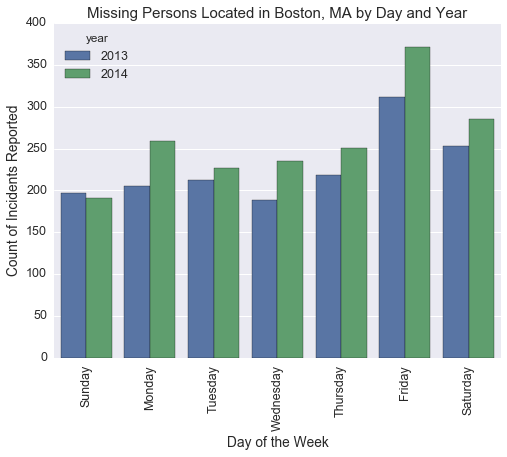

In [32]:
# Visualize with plot

sns.set(font_scale=1.25)
fig1, ax1 = plt.subplots(figsize=(8,6))
sns.countplot(data=df,x='day_week',hue='year',ax=ax1)
ax1.set_title('Missing Persons Located in Boston, MA by Day and Year')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Count of Incidents Reported')
ax1.set_xticklabels(dayOrder,rotation=90)
plt.show()

C:\Users\garymiller01\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


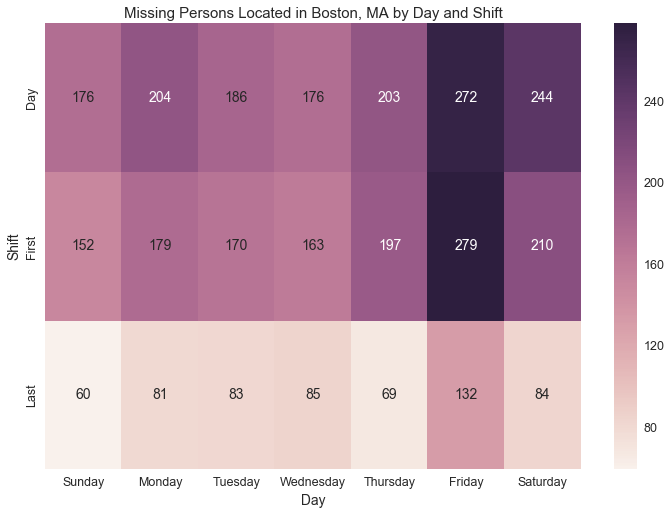

In [33]:
# Count incidents by shift

shiftcrosstab = pd.crosstab(df['shift'],df['day_week'])

# Visualize with heatmap 

sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(12,8))
sns.set_context(font_scale=20)
sns.heatmap(shiftcrosstab,annot=True,fmt='d',ax=ax,xticklabels=dayOrder,annot_kws={'size':14})

ax.set_title('Missing Persons Located in Boston, MA by Day and Shift')
ax.set_xlabel('Day')
ax.set_ylabel('Shift')
plt.show()


   #### What areas of the city have the most cases?
      
   While missing persons have been located throughout the city, the greatest concentrations are in the neighborhoods of Dorchester, Roxbury, and East Boston.  Hyde Park, Roslindale, and West Roxbury don't seem to have as many reported incidents.
   
   Click <a href="http://arcg.is/1poriRs" target="_blank">here</a> to explore the webmap directly in ArcGIS Online.

In [34]:
# Export table to .csv for import into GIS

df.to_csv("F:/DataScienceBlog/05_MissingPersons/MissingPersonsData.csv")

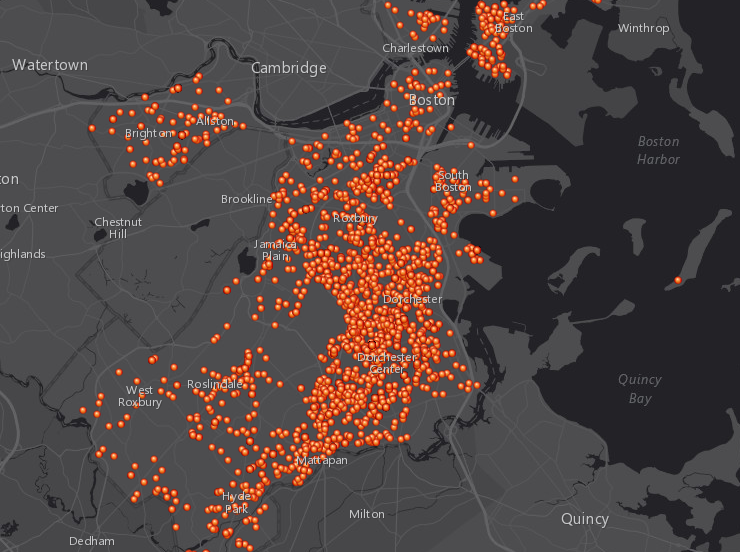

In [35]:
from IPython.display import Image

pointsurl = 'http://www.opendatastories.com/wp-content/uploads/img/04_BostonMissingPersons/MissingPersonsPoints.png'

Image(pointsurl)

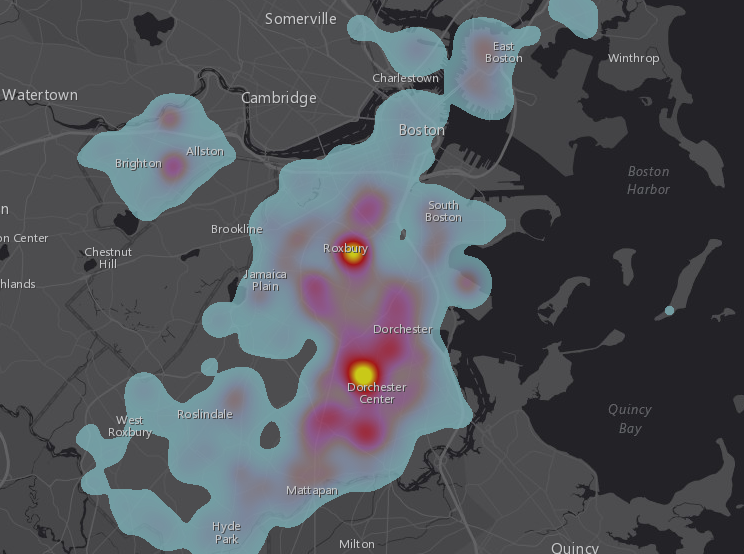

In [36]:
# Display heatmap

heatmapurl='http://www.opendatastories.com/wp-content/uploads/img/04_BostonMissingPersons/MissingPersonsHeatmap.png'

Image(heatmapurl)

# Conclusion

   Despite some limitations, this dataset allowed some important questions about this problem to be answered.  
   
   At the outset of this project, I had hoped to do a more in-depth analysis of each case.  I wanted to look at how long it took each case to get resolved, how far from a person's home or work missing persons end up getting found, etc.  A different source would be needed to take that next step. 